### Pluralsight Data Science Take Home Challenge
Completed by: EJ

#### Contents:
* [Considerations](#first)
* [Imports & Parameters](#second)
* [Data Exploration](#third)
* [Data Cleaning & Normalization](#fourth)
* [Data Modeling](#fifth)
* [Feature Importance](#sixth)
* [Prediction](#seventh)

#### Considerations <a class="anchor" id="first"></a>

Below is a breakdown of some of the considerations I made when generating predictions:

- Data exploration 
    - Categorical vs. Continuous features
    - NaNs/Empty cells
    - Feature distributions, labeled by class (box/ whisker)
    - Class imbalance
- Data cleaning & Prep
    - In-filling erroneous Zeros
    - Normalization
- Modeling
    - Classifiers
    - Hyperparameters
- Feature importance
- Predicting
    - Retrain best model on all data
    - Scale based on training data
    - Predict final labels

#### Imports & Parameters <a class="anchor" id="second"></a>

In [1]:
# Imports
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Parameters
train_portion,test_portion = 0.8, 0.2
k_folds = 5
rand_state = 0

#### Data Exploration <a class="anchor" id="third"></a> 

Takeaways:
- No feature is categorical besides the class label 
- Zeta Positive class is represented about 2-to-1 vs. Zeta Negative
- Potential data errors (Zeros) for BMI, Blood Pressure, Cardio Stress Test

In [3]:
df = pd.read_excel("./data/recruiting_zeta-disease_training-data_take-home-challenge.xlsx") 
print(f'Train set dataframe shape: {df.shape}')
df.head(5)

Train set dataframe shape: (800, 9)


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [4]:
# Check for NaN or empty cells
df.isna().sum()

age                   0
weight                0
bmi                   0
blood_pressure        0
insulin_test          0
liver_stress_test     0
cardio_stress_test    0
years_smoking         0
zeta_disease          0
dtype: int64

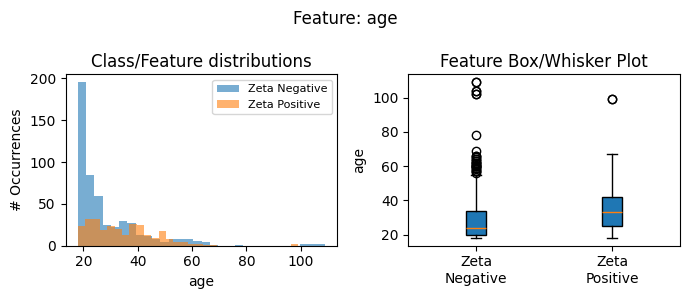

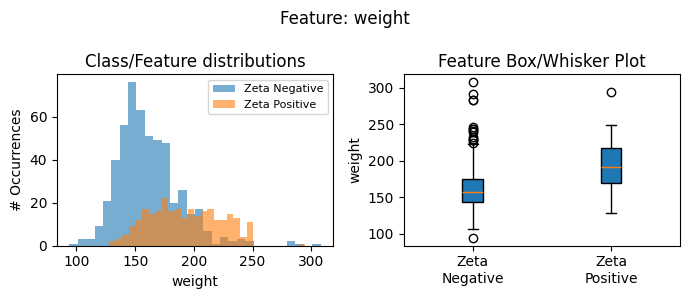

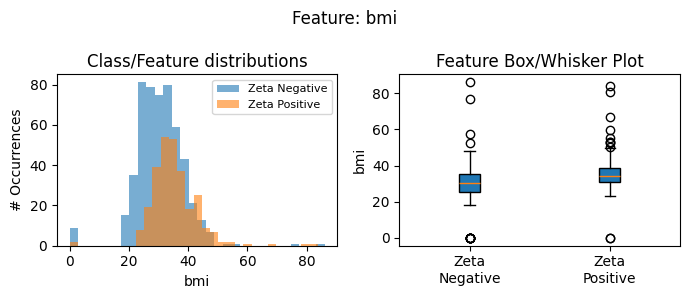

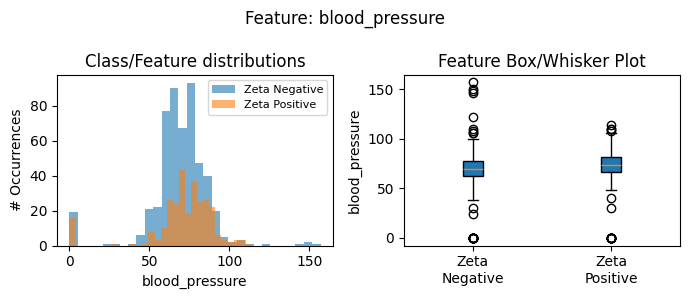

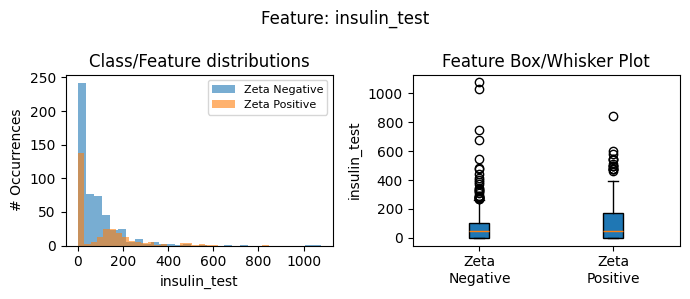

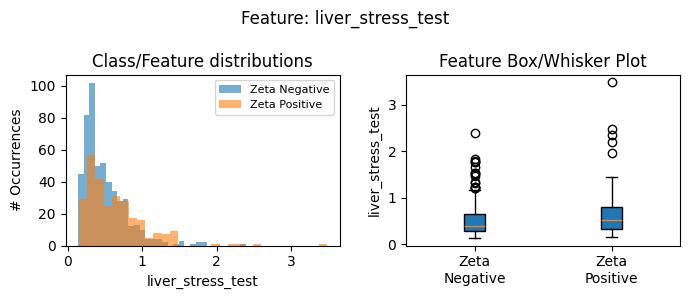

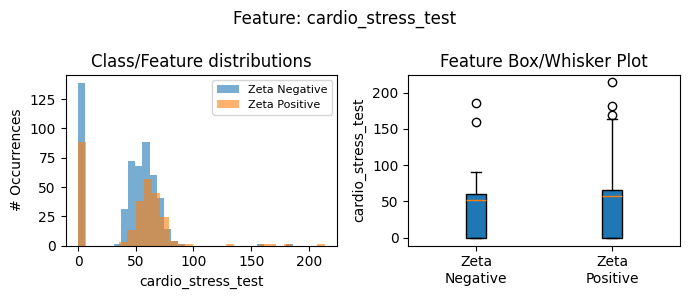

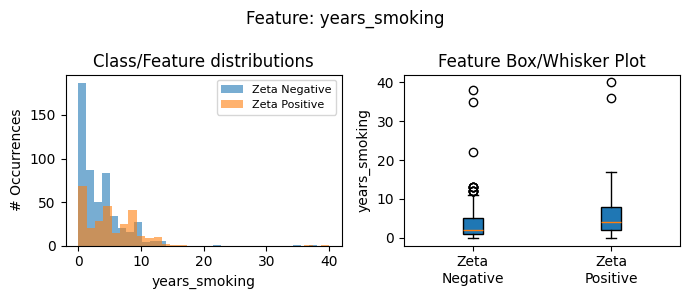

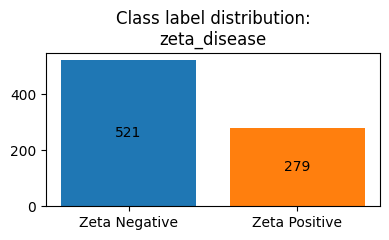

In [5]:
# Plot feature distributions vs. class label
cmap = plt.get_cmap('tab10')
df_nozeta = df.loc[df.zeta_disease == 0]
df_zeta = df.loc[df.zeta_disease == 1]
for col in df:
    
    if col == "zeta_disease":
        plt.figure(figsize=(4,2.5))
        br_plt = plt.bar(["Zeta Negative", "Zeta Positive"], [len(df_nozeta), len(df_zeta)], color=[cmap(0), cmap(1)])
        plt.bar_label(br_plt, [len(df_nozeta), len(df_zeta)], label_type='center')
        plt.title(f'Class label distribution:\n{col}')
    else:
        fig, ax = plt.subplots(1,2,figsize=(7,3))
        ax[0].hist(df_nozeta[col], bins=30, alpha=0.6, label='Zeta Negative')
        ax[0].hist(df_zeta[col], bins=30, alpha=0.6, label='Zeta Positive')
        ax[0].set_xlabel(col)
        ax[0].set_ylabel('# Occurrences')
        ax[0].set_title(f'Class/Feature distributions')
        ax[0].legend(fontsize=8)

        bx_plt = ax[1].boxplot([df_nozeta[col], df_zeta[col]], tick_labels=['Zeta\nNegative', 'Zeta\nPositive'], patch_artist=True)
        ax[1].set_ylabel(col)
        ax[1].set_title(f'Feature Box/Whisker Plot')
        plt.suptitle(f'Feature: {col}')


    plt.tight_layout()
    plt.show()

#### Data Cleaning & Normalization <a class="anchor" id="fourth"></a> 

The BMI, Blood Pressure, and Cardio Stress Test features seem to have erroneous Zeros based on data exploration. Here those zeros are replaced by filling in with the value of the sample's nearest neighbor that doesn't have the Zero.

It is unclear without more domain knowledge if Cardio Stress Test = 0 is a normal test value since it's so common. Here I am assuming it is erroneous (needing to be cleaned) though it may be a valid value.

In [6]:
# Get samples that don't have erroneous Zeros.
err_columns = ['bmi', 'blood_pressure', 'cardio_stress_test']
non_err_df = df.loc[(df.bmi != 0) & (df.blood_pressure != 0) & (df.cardio_stress_test != 0)]

# Standardize based on the clean data.
std_scaler = preprocessing.StandardScaler().fit(non_err_df.iloc[:,:-1])
non_err_df_scaled = std_scaler.transform(non_err_df.iloc[:,:-1])

# Build Neighbor tree based on scaled samples that don't have erroneous Zeros.
knn = NearestNeighbors()
knn.fit(non_err_df_scaled)

# For each column with erroneous Zeros, fill each sample with it's closest clean neighbor's value.
print(f'Training set size without erroneous zeros: {non_err_df.shape}')
df_cleaned = df.copy()
for col in err_columns:
    # Grab erroneous samples for this column.
    col_err_df = df.loc[df[col] == 0]
    print(f'Feature {col}, filling {len(col_err_df)} zeros.')

    # Scale to the same distribution as the standardized clean data.
    col_err_df_scaled = std_scaler.transform(col_err_df.iloc[:,:-1])

    # For each sample, find it's closest neighbor and fill the zero with its neighbor's value.
    neighbor_inds = [x[0] for x in knn.kneighbors(col_err_df_scaled, return_distance=False)]
    for sample, neighbor_i in zip(col_err_df.index, neighbor_inds):
        df_cleaned.at[sample, col] = non_err_df[col].iloc[neighbor_i]

Training set size without erroneous zeros: (569, 9)
Feature bmi, filling 11 zeros.
Feature blood_pressure, filling 35 zeros.
Feature cardio_stress_test, filling 227 zeros.


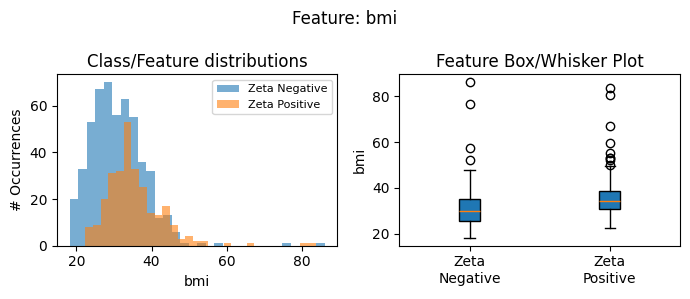

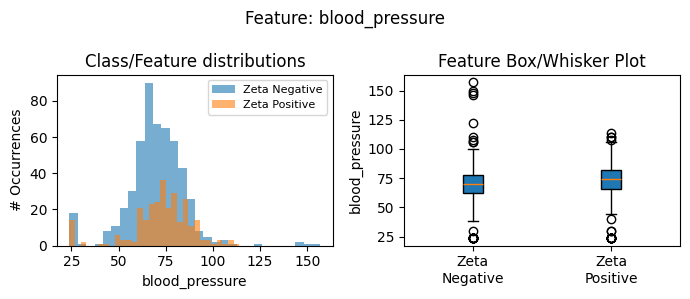

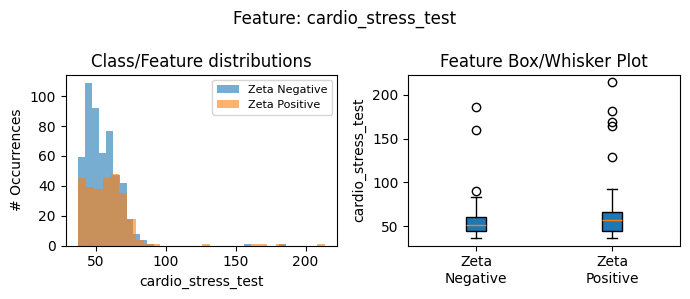

In [7]:
# Confirm that zeros are no longer present for the erroneous columns:
df_nozeta_cleaned = df_cleaned.loc[df_cleaned.zeta_disease == 0]
df_zeta_cleaned = df_cleaned.loc[df_cleaned.zeta_disease == 1]
for col in err_columns:
    fig, ax = plt.subplots(1,2,figsize=(7,3))
    ax[0].hist(df_nozeta_cleaned[col], bins=30, alpha=0.6, label='Zeta Negative')
    ax[0].hist(df_zeta_cleaned[col], bins=30, alpha=0.6, label='Zeta Positive')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('# Occurrences')
    ax[0].set_title(f'Class/Feature distributions')
    ax[0].legend(fontsize=8)

    bx_plt = ax[1].boxplot([df_nozeta_cleaned[col], df_zeta_cleaned[col]], tick_labels=['Zeta\nNegative', 'Zeta\nPositive'], patch_artist=True)
    ax[1].set_ylabel(col)
    ax[1].set_title(f'Feature Box/Whisker Plot')
    plt.suptitle(f'Feature: {col}')
    plt.tight_layout()
    plt.show()

In [8]:
# Standardize the newly-cleaned data using the original clean data's distribution.
df_cleaned_scaled = std_scaler.transform(df_cleaned.iloc[:,:-1])

#### Data Modeling <a class="anchor" id="fifth"></a> 

Test a variety of classifiers by using cross-validation to optimize each classifier's hyperparameters. Here I use an 80-20 train-test split, where 80% of the data is used to cross validate and pick each classifier's best hyperparameters and the remaining 20% is used to to evaluate which classifier performs best outside of its training data.

Without knowing more context, I am assuming that the positive and negative classes are equally important so I train with a class weighting where possible to equally consider each class.

##### Best performing model tested is the Gradient Boosting Classifier.

This would warrant testing XGBoost in the future since it is generally found to be have equal or better performance than Scikit-Learn's Gradient Boosting Classifier. It is also worth noting that Logistic Regression performed nearly equally to the Gradient Boosting Classifier, and would be a top candidate for prediction if a smaller, easily-trained, and low-latency model is desired.

In [9]:
# Split into random stratified train/test split, keeping the portion of 0 to 1 labels for both sets.
df_X = df_cleaned_scaled
df_y = df['zeta_disease'].values

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=train_portion, random_state=rand_state, stratify=df_y)

In [10]:
# Test Logistic Regression Classifier
hyperparams = {
  'penalty': ['elasticnet'], 
  'solver': ['saga'],
  'C': np.logspace(-2, 2, 9), 
  'l1_ratio': np.linspace(0, 1, 11),
  'class_weight': ['balanced'],
  'random_state': [rand_state]
}
hyperparam_grid = GridSearchCV(LogisticRegression(), hyperparams, cv=k_folds, scoring='balanced_accuracy', refit='balanced_accuracy')
hyperparam_grid.fit(X_train, y_train)
print(f'Logistic Regression train set mean cross-validated balanced accuracy: {hyperparam_grid.best_score_:.5f}')

y_pred = hyperparam_grid.predict(X_test)
print(f'Logistic Regression test set balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.5f}')

Logistic Regression train set mean cross-validated balanced accuracy: 0.74265
Logistic Regression test set balanced accuracy: 0.77060


In [11]:
# Test Support Vector Classifier
hyperparams = [
  {'C': np.logspace(-2, 2, 9), 'kernel': ['linear'], 'class_weight': ['balanced'], 'random_state': [rand_state]},
  {'C': np.logspace(-2, 2, 9), 'kernel': ['rbf'], 'gamma': np.logspace(-2, 0, 5)},
]
hyperparam_grid = GridSearchCV(SVC(), hyperparams, cv=k_folds, scoring='balanced_accuracy', refit='balanced_accuracy')
hyperparam_grid.fit(X_train, y_train)
print(f'Support Vector Classifier train set mean cross-validated balanced accuracy: {hyperparam_grid.best_score_:.5f}')

y_pred = hyperparam_grid.predict(X_test)
print(f'Support Vector Classifier test set balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.5f}')

Support Vector Classifier train set mean cross-validated balanced accuracy: 0.73571
Support Vector Classifier test set balanced accuracy: 0.76168


In [12]:
# Test K Nearest Neighbors Classifier
hyperparams = {'n_neighbors': np.arange(1,11), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
hyperparam_grid = GridSearchCV(KNeighborsClassifier(), hyperparams, cv=k_folds, scoring='balanced_accuracy', refit='balanced_accuracy')
hyperparam_grid.fit(X_train, y_train)
print(f'K-Nearest Neighbors Classifier train set mean cross-validated balanced accuracy: {hyperparam_grid.best_score_:.5f}')

y_pred = hyperparam_grid.predict(X_test)
print(f'K-Nearest Neighbors Classifier test set balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.5f}')

K-Nearest Neighbors Classifier train set mean cross-validated balanced accuracy: 0.68884
K-Nearest Neighbors Classifier test set balanced accuracy: 0.67788


In [13]:
# Test Gradient Boosting Classifier
hyperparams = {
    'loss': ['log_loss', 'exponential'], 
    'learning_rate': np.logspace(-2, 2, 5), 
    'n_estimators': [5, 10, 15, 25, 50, 100], 
    'max_depth': [2, 3, 4, 5], 
    'random_state': [rand_state]
}
hyperparam_grid = GridSearchCV(GradientBoostingClassifier(), hyperparams, cv=k_folds, scoring='balanced_accuracy', refit='balanced_accuracy')
hyperparam_grid.fit(X_train, y_train)
print(f'Gradient Boosting Classifier train set mean cross-validated balanced accuracy: {hyperparam_grid.best_score_:.5f}')

y_pred = hyperparam_grid.predict(X_test)
print(f'Gradient Boosting Classifier test set balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.5f}')

Gradient Boosting Classifier train set mean cross-validated balanced accuracy: 0.72641
Gradient Boosting Classifier test set balanced accuracy: 0.77541


#### Feature Importance <a class="anchor" id="sixth"></a> 

Gradient Boosting performs best of the models in my tests. Below is a plot of feature importance as measured by the Gradient Boosting Classifier's default impurity-based metric. The metric shows weight, BMI, then age playing the highest factors in predicting the Zeta Disease. This correlates well with those features appearing to be the most separable in the feature importance plots at the beginning of this notebook. The Liver and Insulin stress test results may also be slightly differentiated visually in the feature distribution plots above and we see a similar conclusion in the feature importance plot below.

Other feature importance metrics like SHAP may yield more accurate importance information, but I stuck with built-in scikit learn functions for this since they agreed qualitatively with the feature distribution plots above.

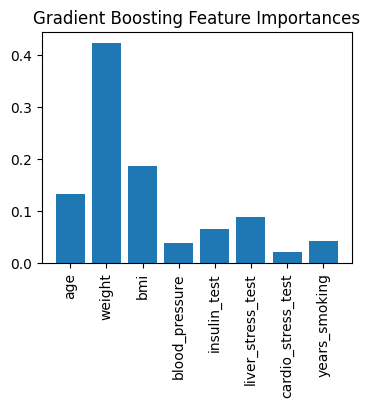

In [14]:
gbc_best_estimator = hyperparam_grid.best_estimator_
plt.figure(figsize=(4,3))
plt.bar(df.columns[:-1], gbc_best_estimator.feature_importances_)
plt.xticks(rotation=90)
plt.title('Gradient Boosting Feature Importances')
plt.show()


#### Prediction <a class="anchor" id="seventh"></a> 

With the best performing model, I perform a final model training on the entire training set before scaling and predicting on the provided prediction set.

As seen in the final plot, the predicted labels seem to match the above feature vs. class label distributions, though it is difficult to be confident with the size of the test set.

In [15]:
# Train and cross validate final Gradient Boosting Classifier on full set
hyperparams = {
    'loss': ['log_loss', 'exponential'], 
    'learning_rate': np.logspace(-2, 2, 5), 
    'n_estimators': [5, 10, 15, 25, 50, 100], 
    'max_depth': [2, 3, 4, 5], 
    'random_state': [rand_state]
}
hyperparam_grid = GridSearchCV(GradientBoostingClassifier(), hyperparams, cv=k_folds, scoring='balanced_accuracy', refit='balanced_accuracy')
hyperparam_grid.fit(df_X, df_y)
print(f'Gradient Boosting Classifier full set mean cross-validated balanced accuracy: {hyperparam_grid.best_score_:.5f}')

gbc_best_estimator = hyperparam_grid.best_estimator_

Gradient Boosting Classifier full set mean cross-validated balanced accuracy: 0.74291


In [16]:
# Load, scale, and Predict on final prediction set.
prediction_df = pd.read_excel("./data/recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx") 
prediction_X_scaled = std_scaler.transform(prediction_df.iloc[:,:-1])
prediction_y = gbc_best_estimator.predict(prediction_X_scaled)
prediction_df['zeta_disease'] = prediction_y

In [17]:
# View the final predictions.
prediction_df

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,1
1,27,179,35.5,89,156,1.6608,43,6,0
2,34,147,26.9,76,74,1.6958,53,2,0
3,35,206,32.4,73,127,1.4608,61,6,1
4,60,193,29.8,62,192,1.7798,65,9,0
5,45,120,36.5,108,50,1.2978,54,12,0
6,20,139,38.2,61,77,1.5818,68,3,0
7,23,137,31.2,70,73,1.4168,59,7,1
8,36,195,30.5,59,141,1.4498,59,6,1
9,19,193,25.8,84,66,1.7938,50,3,0


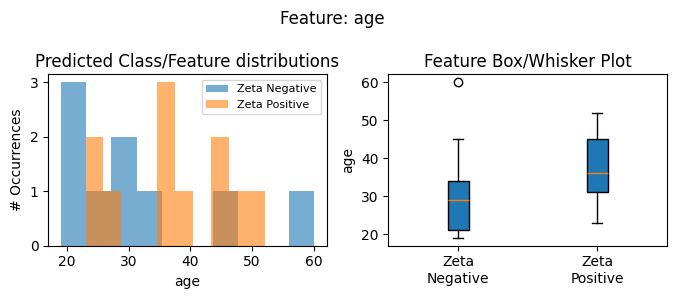

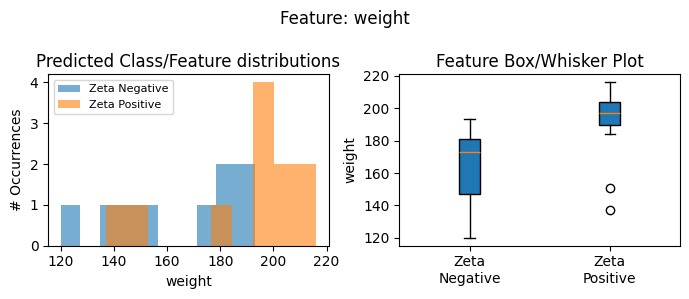

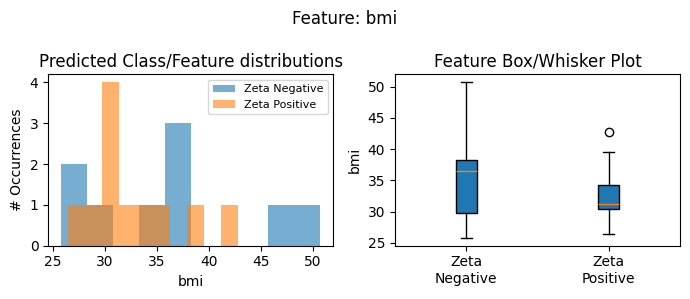

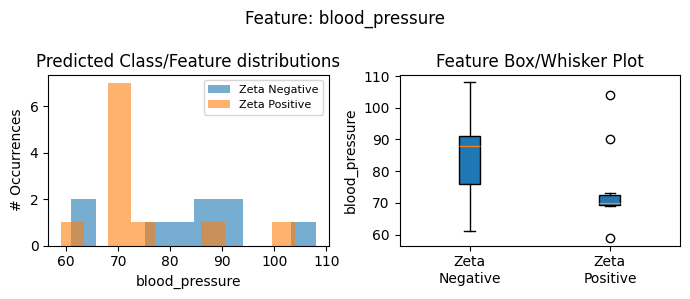

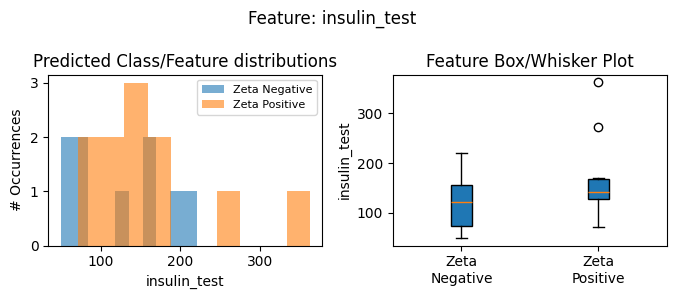

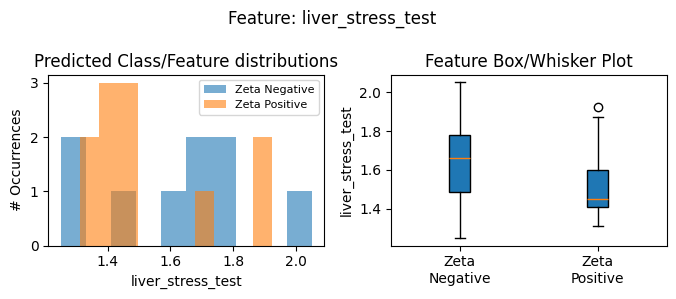

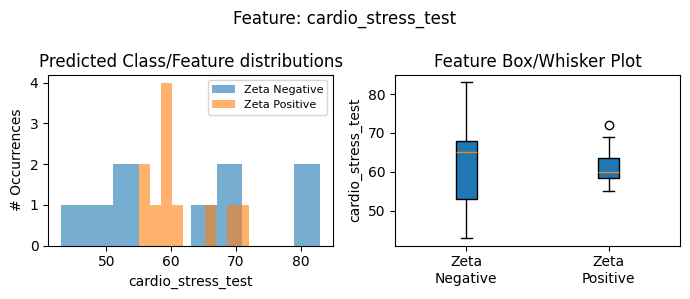

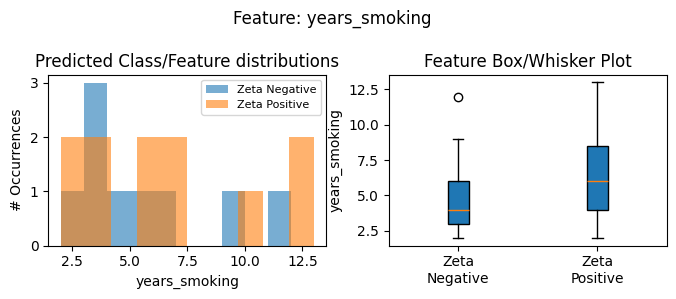

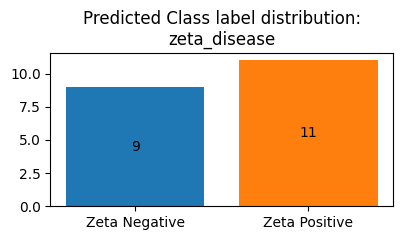

In [18]:
# Plot feature distributions vs. predicted class label
cmap = plt.get_cmap('tab10')
prediction_df_nozeta = prediction_df.loc[prediction_df.zeta_disease == 0]
prediction_df_zeta = prediction_df.loc[prediction_df.zeta_disease == 1]
for col in df:
    
    if col == "zeta_disease":
        plt.figure(figsize=(4,2.5))
        br_plt = plt.bar(["Zeta Negative", "Zeta Positive"], [len(prediction_df_nozeta), len(prediction_df_zeta)], color=[cmap(0), cmap(1)])
        plt.bar_label(br_plt, [len(prediction_df_nozeta), len(prediction_df_zeta)], label_type='center')
        plt.title(f'Predicted Class label distribution:\n{col}')
    else:
        fig, ax = plt.subplots(1,2,figsize=(7,3))
        ax[0].hist(prediction_df_nozeta[col], bins=10, alpha=0.6, label='Zeta Negative')
        ax[0].hist(prediction_df_zeta[col], bins=10, alpha=0.6, label='Zeta Positive')
        ax[0].set_xlabel(col)
        ax[0].set_ylabel('# Occurrences')
        ax[0].set_title(f'Predicted Class/Feature distributions')
        ax[0].legend(fontsize=8)

        bx_plt = ax[1].boxplot([prediction_df_nozeta[col], prediction_df_zeta[col]], tick_labels=['Zeta\nNegative', 'Zeta\nPositive'], patch_artist=True)
        ax[1].set_ylabel(col)
        ax[1].set_title(f'Feature Box/Whisker Plot')
        plt.suptitle(f'Feature: {col}')

    plt.tight_layout()
    plt.show()